# ERROR BARS ON SIGNAL-TO-NOISE MAP FOR BOSS GALAXIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from helper import preprocess_catalog_galactic
from helper import load_catalog
from helper import symmetrize_map
from helper import radial_profile
import pandas as pd

In [2]:
# --- Settings ---
dataset = "BOSS"
if dataset == "eBOSS":
    catalog, region = "LRG", "NGC"
    real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
    rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
elif dataset == "BOSS":
    catalog, region = "CMASS", "North"
    real_file = f"data/BOSS/galaxy_DR12v5_CMASS_{region}.fits"
    rand_file = f"data/BOSS/random0_DR12v5_CMASS_{region}.fits"
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [3]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [4]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

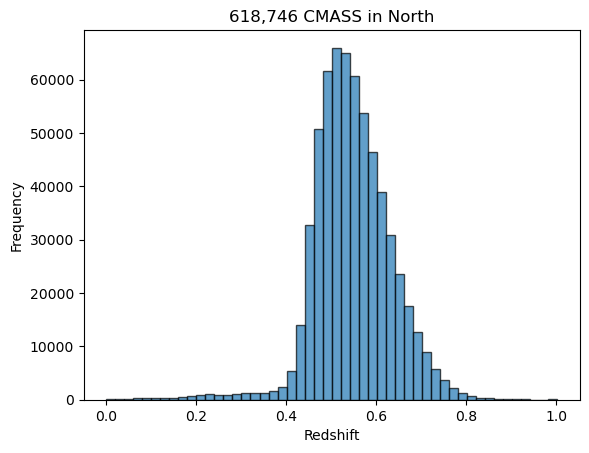

In [5]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load eBOSS LRG catalog ---
with fits.open(real_file) as hd:
    data = hd[1].data

# --- Filter out invalid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [6]:
def assign_jackknife_regions_healpix(catalog, rand_cat, nside=10, threshold=0.9):
    rand_coord = SkyCoord(ra=rand_cat['RA']*u.deg, dec=rand_cat['DEC']*u.deg)
    rand_pix = hp.ang2pix(nside, np.radians(90 - rand_coord.dec.value), np.radians(rand_coord.ra.value))

    unique, counts = np.unique(rand_pix, return_counts=True)
    mean_density = np.mean(counts)
    good_pix = unique[counts > threshold * mean_density]

    gal_coord = SkyCoord(ra=catalog['RA']*u.deg, dec=catalog['DEC']*u.deg)
    gal_pix = hp.ang2pix(nside, np.radians(90 - gal_coord.dec.value), np.radians(gal_coord.ra.value))

    mask = np.isin(gal_pix, good_pix)
    return gal_pix[mask], mask

In [7]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    # --- Preprocess only valid galaxies and convert to Galactic ---
    l_arr, b_arr, D_arr, data, weights_valid = preprocess_catalog_galactic(data, weights)
    # weights = weights[:len(data)]  # Ensure weights match filtered data

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        # if np.minimum(theta) < 0:
            # print(f"{i}: Theta less than zero encountered: {np.min(theta)}")
            # continue
        # if np.maximum(theta) > np.pi:
            # print(f"{i}: Theta greater than zero encountered: {np.max(theta)}")
            # continue
        phi = np.radians(l_grid)
        theta = np.clip(theta, 0, np.pi)  # Ensure valid range
        pix = hp.ang2pix(nside, theta, phi)

        w = weights_valid[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_wk2 += w * κ_vals**2
        sum_w += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [8]:
def jackknife_stack_healpix(data, weights, rand_cat, nside=10, threshold=0.9):
    print("Assigning jackknife regions...")
    jk_regions, valid_mask = assign_jackknife_regions_healpix(data, rand_cat, nside, threshold)
    data, weights = data[valid_mask], weights[valid_mask]
    unique_regions = np.unique(jk_regions)

    kappa_jk = []

    for reg in tqdm(unique_regions, desc="Jackknife (HEALPix)"):
        mask_jk = jk_regions != reg
        data_jk = data[mask_jk]
        weights_jk = weights[mask_jk]
        kappa, _, _ = stack_kappa(data_jk, weights_jk, f"JK-{reg}")
        kappa_jk.append(kappa)

    kappa_jk = np.array(kappa_jk)
    kappa_mean = np.mean(kappa_jk, axis=0)
    kappa_err = np.sqrt((len(kappa_jk) - 1) / len(kappa_jk) * np.sum((kappa_jk - kappa_mean)**2, axis=0))

    return kappa_mean, kappa_err

In [9]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
    plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [10]:
# --- Run all ---
if dataset == "BOSS":
    z_min = .4
    z_max = .7
    weight = "CMASS"
else: # eBOSS
    z_min = 0
    z_max = 10000
    weight = True
print("Loading catalogs...")
data_real, w_real = load_catalog(real_file, weights=weight, z_min=z_min, z_max=z_max)
print("Loading random catalogs...")
data_rand, w_rand = load_catalog(rand_file, weights=False, random_fraction=0.001, z_min=z_min, z_max=z_max)

# Jackknife real galaxies
kappa_real, sigma_real = jackknife_stack_healpix(data_real, w_real, data_rand, nside=10)
sn_real = np.zeros_like(kappa_real)
valid = sigma_real > 0
sn_real[valid] = kappa_real[valid] / sigma_real[valid]
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
# kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Loading catalogs...
Loading random catalogs...


KeyboardInterrupt: 

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


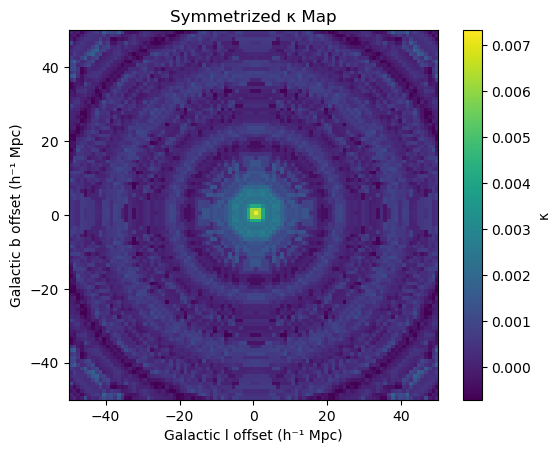

In [22]:
kappa_sym = symmetrize_map(kappa_sub)
plot_map(kappa_sym, "Symmetrized κ Map", cmap='viridis')

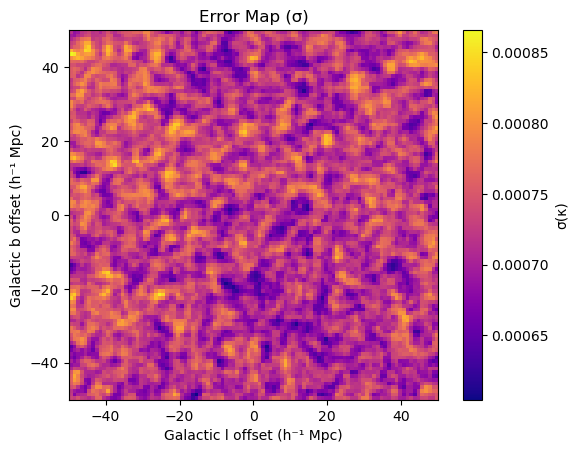

In [23]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

In [24]:
pd.DataFrame(sigma_real).to_csv(r"data/error_map_BOSS_N.csv", index=True)

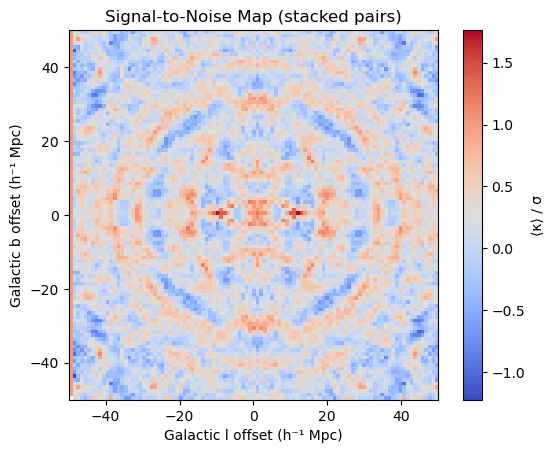

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from helper import preprocess_catalog_galactic
from helper import load_catalog
from helper import symmetrize_map
from helper import radial_profile
import pandas as pd

signal_map = pd.read_csv(r"data/filaments_map_BOSS_20_NS.csv")
error_map = pd.read_csv(r"data/error_map_BOSS_N.csv")

sn_real = signal_map / error_map
plot_map(sn_real, "Signal-to-Noise Map (stacked pairs)", cmap='coolwarm', label='⟨κ⟩ / σ')